### Subset and store  MSI datasets to top20, top10 and top5 most spatially variable metabolites

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import squidpy as sq
from sklearn.preprocessing import StandardScaler
# from sklearn import model_selection
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import os


/home/icb/yufan.xia/tools/apps/mamba/envs/pipeline/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/yufan.xia/tools/apps/mamba/envs/pipeline/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/icb/yufan.xia/tools/apps/mamba/envs/pipeline/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/icb/yufan.xia/tools/apps/mamba/envs/pipeline/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/icb/yufan.xia/tools/apps/mamba/envs/

In [2]:
#Set path to data
# path_msi = "/lustre/groups/ml01/workspace/anastasia.litinetskaya/code/vitatrack/datasets/V11L12-038_A1.MSI_MOSCOT_paired_hvg.h5ad"
path_msi = "/lustre/groups/ml01/workspace/anastasia.litinetskaya/code/vitatrack/datasets/V11L12-038_A1.MSI_MOSCOT_paired.h5ad"


In [3]:
sc.read_h5ad(path_msi)

AnnData object with n_obs × n_vars = 2681 × 2754
    obs: 'technology', 'clusters', 'random_split', 'half_split', 'slide'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_warp'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [4]:
# Set task/dataset name and path to store (keep MSI in the name since it will be used for storing, to differentiate from RNA)
dataset_name  = "V11L12-038_A1.MSI_MOSCOT_paired"
store_dir = "/lustre/groups/ml01/workspace/eirini/hand_prep/"
# name of final data will be a combination of task/dataset_name and topN abundant metabs

In [5]:
adata_msi_full = sc.read_h5ad(path_msi)
# adata_rna_full = sc.read_h5ad(path_rna)

### Prepare MSI data

In [6]:
adata_msi_full

AnnData object with n_obs × n_vars = 2681 × 2754
    obs: 'technology', 'clusters', 'random_split', 'half_split', 'slide'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_warp'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [7]:
adata_msi_full.var_names_make_unique()

In [8]:
adata_msi_full

AnnData object with n_obs × n_vars = 2681 × 2754
    obs: 'technology', 'clusters', 'random_split', 'half_split', 'slide'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_warp'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

#### Quality control (uncomment for unprocessed datasets)

Here you can subset metabolites for noise  
e.g.:  
Remove m/z below FMP10, because most likely this is noise:  
```python
adata_msi_full.var_names  
adata_msi = adata_msi_full[:, adata_msi_full.var_names.astype(float) > 288.15].copy()

In [9]:
# adata_msi = adata_msi_full[:, adata_msi_full.var_names.astype(float) > 288.15].copy()
adata_msi = adata_msi_full.copy()
adata_msi

AnnData object with n_obs × n_vars = 2681 × 2754
    obs: 'technology', 'clusters', 'random_split', 'half_split', 'slide'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_warp'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [10]:
sc.pp.calculate_qc_metrics(adata_msi, inplace=True)


<Axes: xlabel='total_counts', ylabel='Count'>

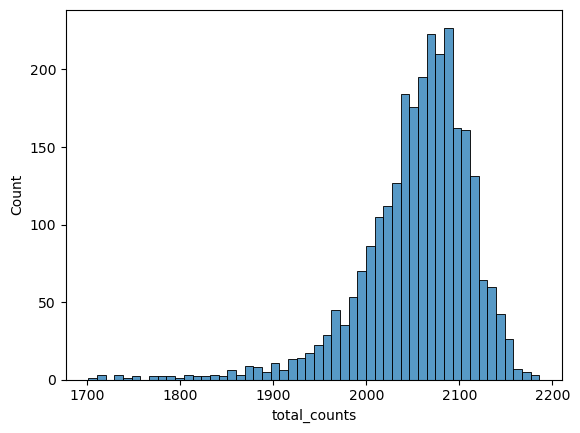

In [11]:
sns.histplot(adata_msi.obs.total_counts) #This sums all the metabolites counted for each cell. 


<Axes: xlabel='n_cells_by_counts', ylabel='Count'>

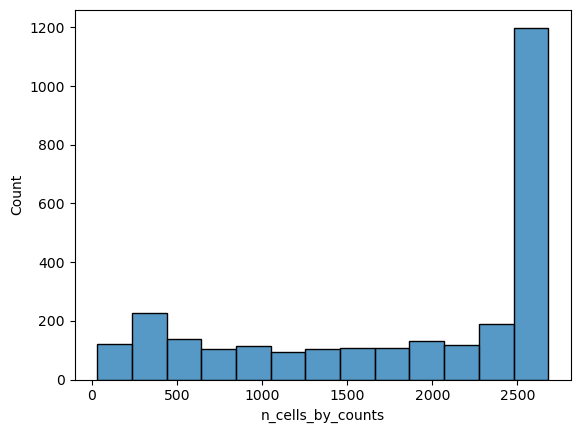

In [12]:
sns.histplot(adata_msi.var.n_cells_by_counts) #This sums # of cells in which each metabolite m/z ratio was found


In [13]:
adata_msi.var.n_cells_by_counts.describe()


count    2754.000000
mean     1854.484386
std       904.224189
min        32.000000
25%      1017.500000
50%      2282.000000
75%      2671.000000
max      2681.000000
Name: n_cells_by_counts, dtype: float64

In [15]:
# Remove highly abundant (since they are most likely noise)
desc = adata_msi.var.n_cells_by_counts.describe()
# Extract the 75% value, then round up to the nearest 50
max_cells_val = int(np.ceil(desc['75%'] / 50.0) * 50)

sc.pp.filter_genes(adata_msi, max_cells=2676)
# or alternatively seet your own number:
# sc.pp.filter_genes(adata_msi, max_cells=1750)


#### Let's identify most spatialy variable metabolites

In [16]:
adata_msi

AnnData object with n_obs × n_vars = 2681 × 2174
    obs: 'technology', 'clusters', 'random_split', 'half_split', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_warp'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

MoranI already present, but just for completeness let's go for the procedure from beginning



In [17]:
# Identify top 5 most spatially variable metabolomes using Moran's I
sq.gr.spatial_neighbors(adata_msi, spatial_key='spatial_warp')
sq.gr.spatial_autocorr(adata_msi)


Do a sorting based first on index, then on Benjamini Hochberg FDR correction pvalue and select the top 30

In [18]:
adata_msi.uns["moranI"]

,I,pval_norm,var_norm,pval_norm_fdr_bh
343.05333,0.756057,0.000000,0.000113,0.000000
838.6165,0.746500,0.000000,0.000113,0.000000
866.6484849999999,0.743828,0.000000,0.000113,0.000000
848.6320350000001,0.735701,0.000000,0.000113,0.000000
867.6533999999999,0.710843,0.000000,0.000113,0.000000
...,...,...,...,...
985.53971,-0.010731,0.165204,0.000113,0.178769
956.007465,-0.011153,0.155548,0.000113,0.169814
808.216595,-0.014762,0.088185,0.000113,0.098013
955.885645,-0.014812,0.087435,0.000113,0.097768


In [19]:
top_30_spat = adata_msi.uns["moranI"].loc[adata_msi.uns["moranI"].pval_norm_fdr_bh < 0.05].sort_values(by=["I", "pval_norm_fdr_bh"], ascending=[False, True]).index[:30]


#### Mini correction for known DHB positive mode matrix peaks, if info for other matrices/modes add the values

In [20]:
mz_values = adata_msi.var_names.astype(float).to_numpy()
mz_values

array([133.074345, 136.52141 , 137.046305, ..., 992.614545, 994.56201 ,
       996.51046 ])

In [21]:
dhb_peaks_positive = np.array([137.0238, 155.0341, 177.0173, 193.0351, 273.0454])
found_peaks = set(mz_values[np.abs(mz_values[:, None] - dhb_peaks_positive[None, :]).min(axis=1) <= 0.1])
found_peaks_str = set(map(str, found_peaks))

# dhb_peaks_negative = np.array([137.0238, 155.0341, 177.0173, 193.0351, 273.0454])
# found_peaks = set(mz_values[np.abs(mz_values[:, None] - dhb_peaks_negative[None, :]).min(axis=1) <= 0.1])
# found_peaks_str = set(map(str, found_peaks))

# fmp10_peaks_positive = np.array([])
# found_peaks = set(mz_values[np.abs(mz_values[:, None] - fmp10_peaks_positive[None, :]).min(axis=1) <= 0.1])
# found_peaks_str = set(map(str, found_peaks))

# fmp10_peaks_negative = np.array([])
# found_peaks = set(mz_values[np.abs(mz_values[:, None] - fmp10_peaks_negative[None, :]).min(axis=1) <= 0.1])
# found_peaks_str = set(map(str, found_peaks))

In [24]:
top_30_spat_filtered = [mz for mz in top_30_spat if mz not in found_peaks_str]
print(top_30_spat_filtered) 
print(len(top_30_spat_filtered))
print(found_peaks)


['343.05333', '838.6165', '866.6484849999999', '848.6320350000001', '867.6533999999999', '864.6305600000001', '839.6182200000001', '849.639235', '852.6320900000001', '364.90382', '518.26212', '866.63671', '364.90545999999995', '850.653705', '822.63419', '556.2165150000001', '850.643975', '832.6490249999999', '364.902325', '853.634125', '850.673965', '335.013615', '546.294005', '630.61329', '381.009', '865.6358299999999', '307.043815', '703.56658', '620.595435', '480.307365']
30
{np.float64(137.04630500000002), np.float64(137.065685), np.float64(137.071495), np.float64(273.04483), np.float64(273.04533000000004), np.float64(273.046), np.float64(273.028295), np.float64(273.02946), np.float64(273.029965), np.float64(273.03063), np.float64(273.03112999999996), np.float64(273.032135), np.float64(273.0328), np.float64(155.06254), np.float64(177.01229999999998), np.float64(273.04984), np.float64(273.03330500000004), np.float64(273.03380500000003), np.float64(273.03497500000003), np.float64(273

In [26]:
np.all(top_30_spat == top_30_spat_filtered)

np.True_

In [27]:
# #If you dont want to do the matrix peaks cleaning, just comment out previous part and uncomment this:
# top_30_spat_filtered = top_30_spat

In [28]:
top_5_spat_metabolites = top_30_spat_filtered[:5]
top_10_spat_metabolites = top_30_spat_filtered[:10]
top_20_spat_metabolites = top_30_spat_filtered[:20]
adata_msi_top5_spat = adata_msi[:, adata_msi.var_names.isin(top_5_spat_metabolites)].copy()
adata_msi_top10_spat = adata_msi[:, adata_msi.var_names.isin(top_10_spat_metabolites)].copy()
adata_msi_top20_spat = adata_msi[:, adata_msi.var_names.isin(top_20_spat_metabolites)].copy()

#### Store the created dataset full in the directory of choice, under {original_dataset_name}_topNspatvar.h5ad

In [29]:
adata_msi_top5_spat

AnnData object with n_obs × n_vars = 2681 × 5
    obs: 'technology', 'clusters', 'random_split', 'half_split', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_warp'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [ ]:
/lustre/groups/ml01/workspace/eirini/hand_prep

'/lustre/groups/ml01/workspace/eirini/hand_prep/'

In [31]:
adata_msi_top5_spat.write(os.path.join(store_dir, f"{dataset_name}_top5spatvar.h5ad"))
adata_msi_top10_spat.write(os.path.join(store_dir, f"{dataset_name}_top10spatvar.h5ad"))
adata_msi_top20_spat.write(os.path.join(store_dir, f"{dataset_name}_top20spatvar.h5ad"))

In [33]:
# adata_msi_top5_spat

### Processed Dataset Setup for Feature Selection

The following instructions explain how to avoid re-preprocessing the data in the main pipeline. The `run_featsel` step will skip preprocessing if the data already exists in the output directory of the `feat_sel` rule.

### Steps

1. **Manually Create Processed Datasets**

   - Copy the processed RNA test and train splits from the corresponding RNA dataset (choose one from *vitatrack*, *neuro*, or *lipids*).

2. **Place Data in the Pipeline Directory**

   - Copy the processed datasets from the previous step into the pipeline's workspace directory.
   - Rename the folder as needed (e.g., using the task name specified in `config.yaml`):
     
     ```bash
     /lustre/groups/ml01/workspace/eirini.giannakoulia/{task_name}_topN_spatvar
     ```

3. **Add Processed MSI Data**

   - Run the remaining notebook to add the processed MSI data into all the feature selection folders

3. **Paste in pipeline**

   - Paste under:
   ```bash
     pipeline/dataset/processed/{task_name}_topN_spatvar
     ```




After completing these steps, your pipeline is ready to run without reprocessing the data.


In [ ]:
# task_name = "V11L12-038_A1_MOSCOT_paired"
# split = "split"

In [47]:
# base_dir = f"/lustre/groups/ml01/workspace/eirini.giannakoulia/{task_name}_top5_spatvar"
# adata_msi_top5_spat_train = adata_msi_top5_spat[adata_msi_top5_spat.obs["half_split" ]== "train"].copy()
# adata_msi_top5_spat_test = adata_msi_top5_spat[adata_msi_top5_spat.obs["half_split" ]== "test"].copy()

# for feat_sel in ["hvg", "hvg_svd", "hvg_svd_graph", "svd", "svd_graph"]:
#     adata_msi_top5_spat_train.write(os.path.join("/lustre/groups/ml01/workspace/eirini.giannakoulia/lipids_top5_spatvar",feat_sel,"msi_dataset_train.h5ad"))
#     adata_msi_top5_spat_test.write(os.path.join("/lustre/groups/ml01/workspace/eirini.giannakoulia/lipids_top5_spatvar",feat_sel,"msi_dataset_test.h5ad"))


In [ ]:
base_dir = f"/lustre/groups/ml01/workspace/eirini/{task_name}_top10_spatvar"
adata_msi_top10_spat_train = adata_msi_top10_spat[adata_msi_top10_spat.obs[split]=="train"].copy()
adata_msi_top10_spat_test = adata_msi_top10_spat[adata_msi_top10_spat.obs[split]=="test"].copy()

for feat_sel in ["hvg", "hvg_svd", "hvg_svd_graph", "svd", "svd_graph"]:
    # Create the directory if it doesn't exist
    out_dir = os.path.join(base_dir, feat_sel)
    os.makedirs(out_dir, exist_ok=True)

    # Write the files
    adata_msi_top10_spat_train.write(os.path.join(out_dir, "msi_dataset_train.h5ad"))
    adata_msi_top10_spat_test.write(os.path.join(out_dir, "msi_dataset_test.h5ad"))


In [50]:
adata_msi_top10_spat

AnnData object with n_obs × n_vars = 2681 × 10
    obs: 'technology', 'clusters', 'split', 'og_index'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'raw_counts', 'spatial', 'spatial_warp'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [51]:
base_dir = f"/lustre/groups/ml01/workspace/eirini.giannakoulia/{task_name}_top20_spatvar"

adata_msi_top20_spat_train = adata_msi_top20_spat[adata_msi_top20_spat.obs[split]=="train"].copy()
adata_msi_top20_spat_test = adata_msi_top20_spat[adata_msi_top20_spat.obs[split]=="test"].copy()


In [ ]:
# Cross check if var size is correct
adata_msi_top20_spat_train


In [ ]:
for feat_sel in ["hvg", "hvg_svd", "hvg_svd_graph", "svd", "svd_graph"]:
    out_dir = os.path.join(base_dir, feat_sel)
    os.makedirs(out_dir, exist_ok=True)
    
    adata_msi_top20_spat_train.write(os.path.join(out_dir, "msi_dataset_train.h5ad"))
    adata_msi_top20_spat_test.write(os.path.join(out_dir, "msi_dataset_test.h5ad"))
